In [1]:
import numpy as np
import matplotlib as mpl
# Pointer to locally stored FFMPEG excecutable, commented out for submission, but uncommented when used on local machine to obtain results
#mpl.rcParams['animation.ffmpeg_path'] = r"C:\Users\dcool\Downloads\ffmpeg-2021-12-09-git-b9f4c1231f-full_build\bin\ffmpeg.exe"
from matplotlib import pyplot as plt
import copy as cp
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
import matplotlib.cm as cm

In [2]:
# Constructs an nxn matrix to describe the system of differential equations
# ith row in the matrix = theta_double_dot_i diff eq
# jth column in the matrix = coefficient of theta_j
def get_weight_matrix(n, m, l, g):
    # Gets weight matrix of initial theta values
    m_theta = np.identity(n)
    for k in range(n):
        m_theta[k,k] = -g*l[k]*np.sum(m[0:n-k])
    print("theta matrix: \n", m_theta)
    print('\n')

    # Gets weight matrix of initial theta double dot values
    m_theta_dd = np.identity(n)
    for k in range(n):
        for j in range(n):
            m_theta_dd[k,j] = l[j]*l[k]*np.sum(m[np.max((k,j)):n])
    print("theta_double_dot matrix: \n",m_theta_dd)
    print('\n')

    # Matrix multiplication, effectivelly re-arranging terms such that
    ##the weight matrix is the matrix of coefficients_ij of the theta_ij
    ##values for the diffeqs governed by an identity matrix of theta_double_dot_i's
    ##where i = rows, j = columns
    inv_m_theta_dd = np.linalg.inv(m_theta_dd)
    weight_matrix = inv_m_theta_dd@m_theta
    print("system of equations/weight matrix:\n", weight_matrix)
    
    return weight_matrix

In [3]:
# Constructs an nxn matrix to describe the system of differential equations
# ith row in the matrix = theta_double_dot_i diff eq
# jth column in the matrix = coefficient of theta_j

# This function is only included for illustration purposes to accompany the section of the writeup for the 
## identical massess, identical lengths section. The get_weight_matrix() is much more functional and robust, and is used
def get_matrix(n):
    mat = np.zeros((n,n))
    for i in range(n):
        try:
            mat[i, i] = 2*(n-i)
            mat[i+1, i] = -(n-i)
            mat[i-1, i] = -(n-i)
        except IndexError:
            pass
    # Fixing errors for the matrix
    mat[0][0] = n
    mat[n-2][-1] = -1
    # n = 2 and n = 1 are special cases
    if (n > 2):
        mat[-1][0] = 0.
    return mat

In [4]:
def get_f(M, theta, n):
    f = cp.deepcopy(M)*0
    for i in range(n):
        f[i,i] = M[i,i]*theta[i,i]
        try:
            f[i+1,i] = M[i+1,i]*theta[i+1,i] #the theta values here are i+1,i+1 because this is always a diagonal matrix,
            # we are using a weird convention here where we are representing the theta in slices of time as the diagonals of a matrix,
            # instead of as a vector
        except IndexError:
            pass
        try:
            f[i-1,i] = M[i-1,i]*theta[i-1,i]
        except IndexError:
            pass
    return f

In [5]:
def recover_position(r_t, v_t, n, l, mode = "pos"):
    # Recovering theta_t values from tensor of matricees into matrix of vectors
    delr_t = []
    onearr = np.ones(n)
    delr_t = r_t@onearr

    # Recover position over time
    if (mode == "pos"):
        delx_t = l*np.sin(delr_t)
        dely_t = -1*(l*np.cos(delr_t))

    # Recover velocity over time
    if (mode == "vel"):
        delv_t = v_t@onearr
        delx_t = l*np.cos(delr_t)*delv_t
        dely_t = -1*(l*np.sin(delr_t)*delv_t)

    x_t = np.zeros_like(delx_t)
    y_t = np.zeros_like(dely_t)

    # Populating matrix of x_t and y_t as indicated in writeup
    for k in range(len(delx_t)):
        x_t[k,0] = delx_t[k,0]
        y_t[k,0] = dely_t[k,0]
        for j in range(1, n):
            x_t[k,j] = np.sum(delx_t[k][0:j+1])
            y_t[k,j] = np.sum(dely_t[k][0:j+1])

    return x_t, y_t

In [6]:
def verlet_pendulum(r_0, v_0, mat, n, h, tf, m, l, delta, g = 9.81):
    # Calculating first Half-step of v for verlet method
    v_half_0 = v_0 + 0.5*h*get_f(mat, r_0, n)

    h_t = []
    r_t = []
    v_t = []
    v_half_t = []

    r_t.append(r_0)
    v_t.append(v_0)
    v_half_t.append(v_half_0)

    t_final = 0.
    h_t.append(t_final)

    while(t_final < tf):
        good_step = False
        while(good_step == False):
            # Calculating first Verlet timestep of size h
            r1 = r_0 + h*v_half_0 # calculating r(t + h)
            k1 = h*get_f(mat, r1, n) # calculating k
            v1 = v_half_0 + 0.5*k1 # calculating v(t + h)
            v_half_01 = v_half_0 + k1 # calculating v(t + 3/2h)
            r_01 = cp.deepcopy(r1) # updating r(t) previous
            # Calculating second Verlet timestep of size h
            r1 = r_01 + h*v_half_01 # calculating r(t + h)
            k1 = h*get_f(mat, r1, n) # calculating k
            v1 = v_half_01 + 0.5*k1 # calculating v(t + h)
            v_half_01 = v_half_01 + k1 # calculating v(t + 3/2h)

            # Calculating Verlet timestep of size 2h
            r2 = r_0 + 2.*h*v_half_0 # calculating r(t + h)
            k2 = 2.*h*get_f(mat, r2, n) # calculating k
            v2 = v_half_0 + 0.5*k2 # calculating v(t + h)
            v_half_02 = v_half_0 + k2 # calculating v(t + 3/2h)

            # Matrix of errors, diagonals are the errors of each of the theta values calculated
            epsilon = (1./30.)*(r1 - r2)

            # Calculating total error in r
            epsilon = epsilon**2
            epsilon_sum = 0.
            ep_ones = np.ones(n)
            epsilon_sum = epsilon@ep_ones
            epsilon_sum = np.sum(epsilon_sum)

            # Calculating rho value to determine whether or not step size should be increased or decreased
            rho = (epsilon_sum**(-0.5))*h*delta

            if (rho > (1 - delta)): #if rho is close enough to 1 to desired accuracy, let it through
                h = (rho**(0.25))*h
                t_final += h
                h_t.append(t_final)
                good_step == True # "good step == true" alone doesn't break it out of the while loop
                break
            elif (rho <= (1 - delta)):
                h = (rho**(0.25))*h
            else:
                print('ERROR')

        #Using local extrapolation to determine more accurate r1 & v1 values
        r_le = r1 + (1./15.)*(r1 - r2)
        v_le = v1 + (1./15.)*(v1 - v2)

        # Storing good values of theta (r1) and theta dot (v1)
        r_t.append(r_le)
        v_t.append(v_le)

        #v_half_0 = v_half_01 + k1
        v_half_0 = cp.deepcopy(v_half_01) # updating v(t + 3/2h) previous
        r_0 = cp.deepcopy(r1) # updating r(t) previous
    
    return r_t, v_t, h_t

In [7]:
def animate(i, l_tot, n, m, l, x_t, y_t, h_t):
    ax1.clear()
    ax1.set_ylim(-l_tot,l_tot)
    ax1.set_xlim(-l_tot,l_tot)
    ax1.set_xlabel("Position (x)", size = 15)
    ax1.set_ylabel("Position (y)", size = 15)
    ax1.set_title("Motion of " + str(n) + "-mass Pendulum Over Time", size = 15)
    x_plts_init = np.array((0, x_t[0][0]))
    y_plts_init = np.array((0, y_t[0][0]))
    ax1.plot(x_plts_init,y_plts_init, marker = "o", linestyle="dashed", color = "black", label = "Initial Position")
    ax1.text(-l_tot*0.8,l_tot*0.8,"Time = " + str(h_t[i*rate]), fontsize=16, fontweight = "bold")
    for j in range(0, n-1):
        cmap = cm.get_cmap('viridis')
        x_plts = np.array((x_t[i*rate][n-1 - j], x_t[i*rate][n-1 - (j + 1)]))
        y_plts = np.array((y_t[i*rate][n-1 - j], y_t[i*rate][n-1 - (j + 1)]))
        ax1.plot(x_plts,y_plts, marker = "o", label = "Mass" + str(n - j) + ', with mass=' + str(m[n-j-1]) + ', length=' + str(l[n-j-1]) + ',\n theta0 = ' + str(np.round(theta_init[n-j-1],3)), markersize = m[n - j -1]*2, color = cmap((n - j)/n))
        x_plts_init = np.array((x_t[0][j], x_t[0][j + 1]))
        y_plts_init = np.array((y_t[0][j], y_t[0][j + 1]))
        ax1.plot(x_plts_init,y_plts_init, marker = "o", linestyle="dashed", color = "black")
    x_plts = np.array((0, x_t[i*rate][0]))
    y_plts = np.array((0, y_t[i*rate][0]))
    ax1.plot(x_plts,y_plts, marker = "o", label = "Mass1, with mass =" + str(m[0])+ ', length=' + str(l[0]) + ',\n theta0 = ' + str(np.round(theta_init[0],3)), markersize = m[0]*2, color = cmap(1/n))
    ax1.legend(prop={'size': 10}, loc = 'upper right')
    return line,

In [8]:
%%time
# Defining Parameters, change these values to change the pendulum system
# Note: the length of the m and l vectors must be n
n = 4
g = 9.81
l = np.ones(n)
m = np.ones(n)*2. # Multiplying by 2 for visibility on plot, for identical massess and identical lengths this makes no difference to final calculation
tf = 2*np.pi
h = tf/400.
times = np.arange(h, tf+h, h)

# Initial Conditions, change the ith diagonal values only to change the initial conditions for the 
## ith pendulum
r_0 = np.identity(n)*3.*np.pi/4.
v_0 = np.zeros_like(r_0)

theta_init = r_0@np.ones(n)

# Matix of weights for diffeq
mat = get_weight_matrix(n, m, l, g)

# Setting Target accuracy
delta = 1e-3

theta matrix: 
 [[-78.48   0.     0.     0.  ]
 [  0.   -58.86   0.     0.  ]
 [  0.     0.   -39.24   0.  ]
 [  0.     0.     0.   -19.62]]


theta_double_dot matrix: 
 [[8. 6. 4. 2.]
 [6. 6. 4. 2.]
 [4. 4. 4. 2.]
 [2. 2. 2. 2.]]


system of equations/weight matrix:
 [[-39.24  29.43   0.     0.  ]
 [ 39.24 -58.86  19.62   0.  ]
 [  0.    29.43 -39.24   9.81]
 [  0.     0.    19.62 -19.62]]
Wall time: 8.17 ms


In [9]:
%%time
# Verlet Method to Solve Diff Eq system
r_t, v_t, h_t = verlet_pendulum(r_0, v_0, mat, n, h, tf, m, l, delta)

Wall time: 6.22 s


In [10]:
%%time
# Recovering position and velocity values from matrix
x_t, y_t = recover_position(r_t, v_t, n, l, mode = "pos")
xdot_t, ydot_t = recover_position(r_t, v_t, n, l, mode = "vel")

Wall time: 1.61 s


In [11]:
# Determines Rate to ensure that there are less than 1000 frames in the gif
# Limit on frames per animation is 1000 for google drive
ideal_rate = len(h_t)
rate = 1
while (ideal_rate/rate > 800):
    rate += 1

<IPython.core.display.Javascript object>


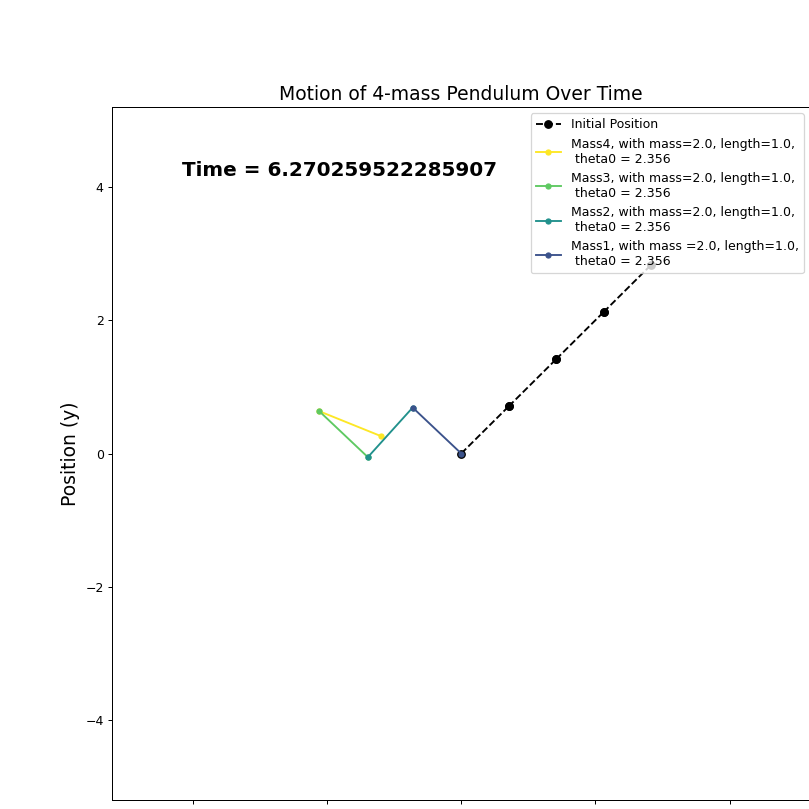

Wall time: 1min 19s


In [12]:
%%time
%matplotlib notebook

# Getting colour map to colour masses in a colour-blind friendly colour map
cmap = cm.get_cmap('viridis')

# Make an animated plot
l_tot = np.sum(l)*1.3
fig1,ax1=plt.subplots(figsize=(10,10))
x_plts = (x_t[0][0], x_t[0][1])
y_plts = (y_t[0][0], y_t[0][1])
line,=ax1.plot(x_plts,y_plts,'r:')
ax1.set_ylim(-l_tot,l_tot)
ax1.set_xlim(-l_tot,l_tot)

def a(i):
    animate(i, l_tot = l_tot, n = n, m = m, l = l, x_t = x_t, y_t = y_t, h_t = h_t)

anim = FuncAnimation(fig1, a, frames=int(len(h_t)/rate), interval=1,repeat=False,blit=True)

plt.show()

file = "Animation_for_n_equals_" + str(n) + "_pendulum_rate_" + str(rate) + "_identical_mass_identical_length_init_angle_3pi_over_4" + ".mp4"
writervideo = animation.FFMpegWriter(fps=30) 
anim.save(file, writer=writervideo)

# To save animation as a .gif file, commented by default since .mp4 prefered
#writergif = animation.PillowWriter(fps=30) 
#anim.save(file, writergif)

In [13]:
def get_energy(x_t, y_t, xdot_t, ydot_t, r_t, v_t, h_t, n, l, m, winsize = 1000, filename1 = "test", filename2 = "test", mode = "acc", endtime = -1, save_cond = False):
    # Determine plot of total energy over time
    if (mode == "acc"):
        # Calculating energy using functions of actual energy
        pot_E = m*y_t
        pot_E = np.sum(pot_E, 1)
        pot_E = pot_E*g

        kin_E = xdot_t**2 + ydot_t**2
        kin_E = m*kin_E
        kin_E = np.sum(kin_E,1)
        kin_E = 0.5*kin_E
        kin_E = cp.deepcopy(kin_E)
        
        comptype = "actual"
    elif (mode == "approx"):
        # Calculating energy using small angle approximation functions of energy
        delr_t = r_t@np.ones(n)

        delr_t = delr_t**2
        delr_t = l*delr_t
        cumsum_r_t = np.zeros_like(delr_t)
        for k in range(len(delr_t)):
            cumsum_r_t[k,0] = delr_t[k,0]
            for j in range(1, n):
                cumsum_r_t[k,j] = np.sum(delr_t[k][0:j+1])

        pot_E = m*cumsum_r_t
        pot_E = np.sum(pot_E, 1)
        pot_E = (g/2.)*pot_E

        delv_t = v_t@np.ones(n)

        delv_t = l*delv_t
        cumsum_v_t = np.zeros_like(delv_t)
        for k in range(len(delv_t)):
            cumsum_v_t[k,0] = delv_t[k,0]
            for j in range(1, n):
                cumsum_v_t[k,j] = np.sum(delv_t[k][0:j+1])

        kin_E = cumsum_v_t**2
        kin_E = m*kin_E
        kin_E = np.sum(kin_E, 1)
        kin_E = 0.5*kin_E
        
        comptype = "approx"

    tot_E = pot_E + kin_E

    times = np.arange(0, len(tot_E), 1)

    # Make Energy Plot
    plt.figure(figsize = (16,9))
    plt.plot(h_t[0:endtime], tot_E[0:endtime], label = "Total Energy", linewidth = 2, color='black')
    plt.plot(h_t[0:endtime], pot_E[0:endtime], label = "Potential Energy", linestyle = 'dashed', color = "#19D5FF")
    plt.plot(h_t[0:endtime], kin_E[0:endtime], label = "Kinetic Energy", linestyle = 'dashed', color = "#F43A13")
    plt.xlabel("Time", size = 18)
    plt.ylabel("Energy", size = 18)
    if (comptype == "actual"):
        plt.title("Energy vs Time for " + str(n) + " Pendulum", size = 20)
    elif (comptype == "approx"):
        plt.title("Small Angle Approximation Energy vs Time for " + str(n) + " Pendulum", size = 20)
    plt.legend(prop={'size': 16}, loc = 'upper right')
    if (save_cond == True):
        plt.savefig("Energy_Time_" + str(n) + "_pendulum_" + comptype + "_" + filename1 + ".png")
    plt.show()

    # Make Rolling Average of Energy Plot
    rolling_avg = np.convolve(tot_E, np.ones(winsize)/winsize, mode='valid')
    print(np.convolve(tot_E, np.ones(winsize)/winsize, mode='valid'))
    plt.figure(figsize = (9,9))
    plt.plot(np.arange(0, len(rolling_avg), 1), rolling_avg)
    plt.xlabel("Timestep", size = 18)
    plt.ylabel("Energy", size = 18)
    if (comptype == "actual"):
        plt.title("Rolling Average of Energy vs Time for " + str(n) + " Pendulum,\n Window Size = " + str(winsize), size = 20)
    elif (comptype == "approx"):
        plt.title("Small Angle Approx Rolling Average of Energy vs Time\n for " + str(n) + " Pendulum, Window Size = " + str(winsize), size = 20)
    if (save_cond == True):
        plt.savefig("Energy_Rolling_Avg" + str(n) + "_pendulum_" + comptype + "_windowsize_" + str(winsize) + "_" + filename2 + ".png")
    plt.show()

In [14]:
# Getting Values for Large Final Time
r_t, v_t, h_t = verlet_pendulum(r_0, v_0, mat, n, h, 10, m, l, delta)
x_t, y_t = recover_position(r_t, v_t, n, l, mode = "pos")
xdot_t, ydot_t = recover_position(r_t, v_t, n, l, mode = "vel")

<IPython.core.display.Javascript object>


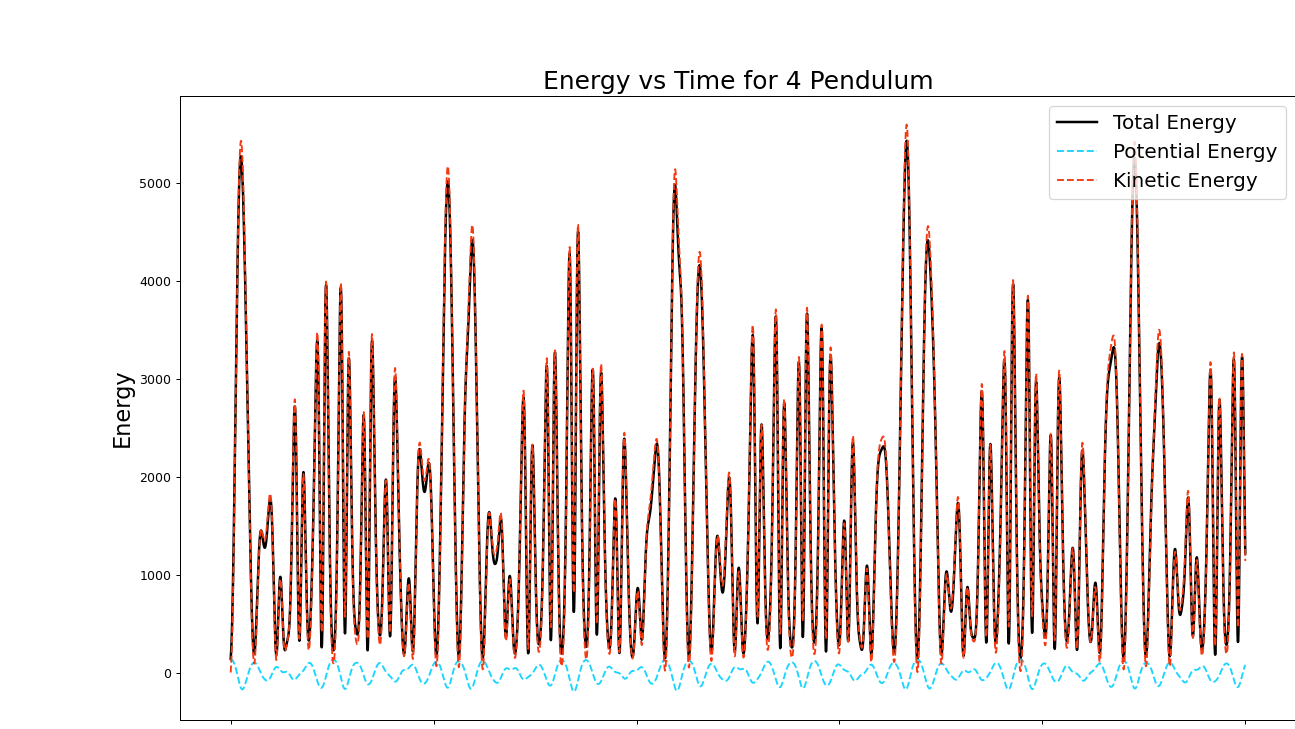

[1504.11726832 1504.11849737 1504.11790984 ... 1421.64922025 1421.59150037
 1421.53096786]


<IPython.core.display.Javascript object>


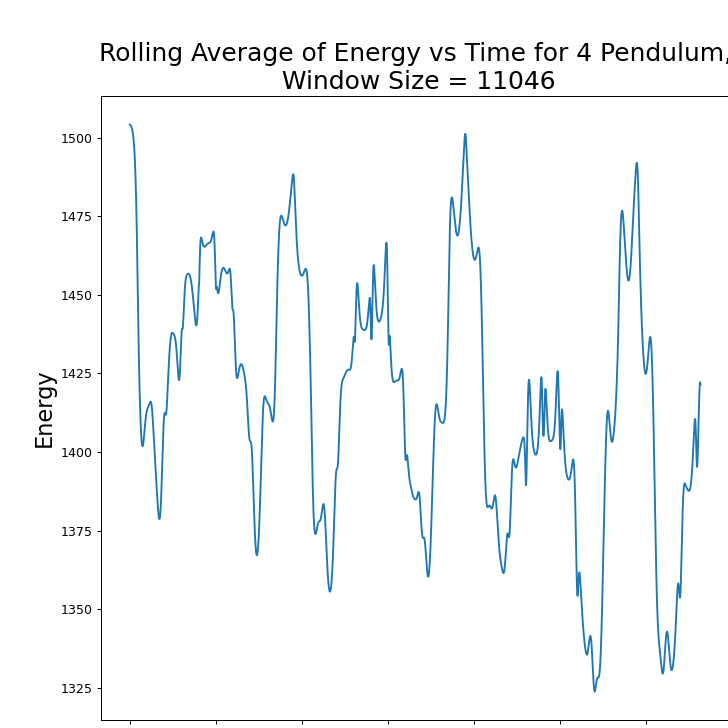

<IPython.core.display.Javascript object>


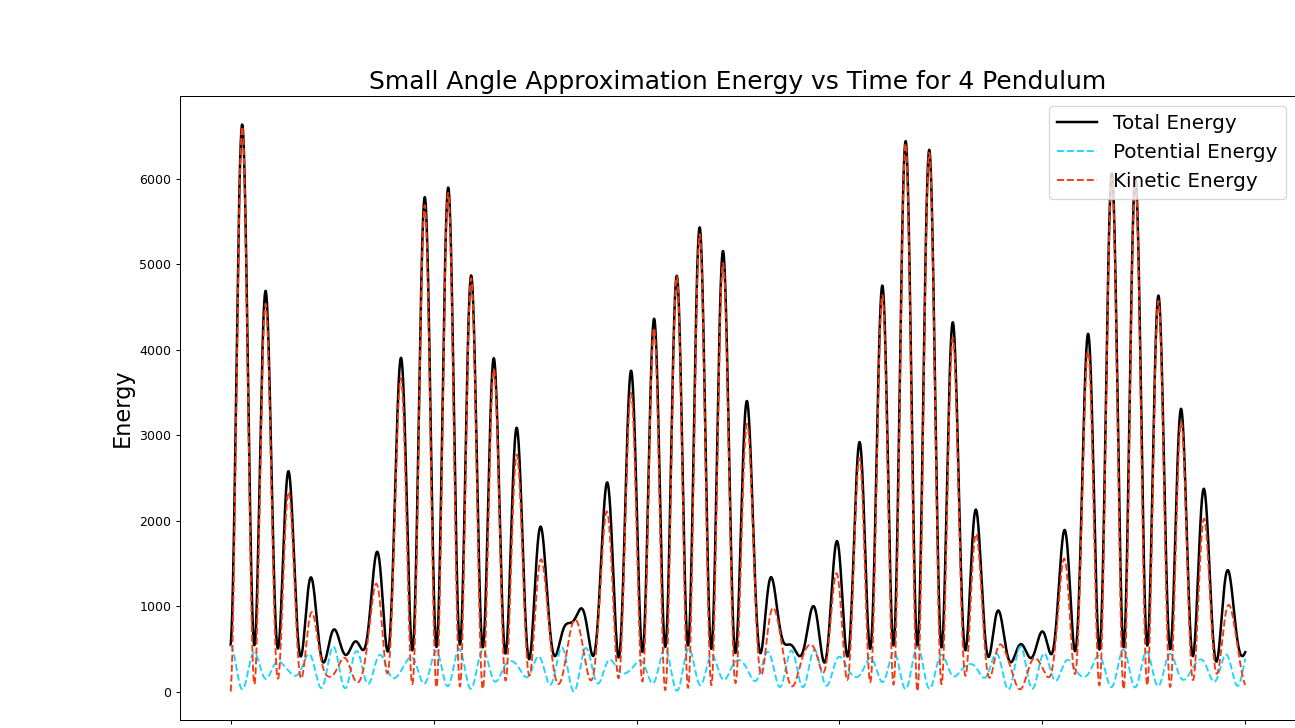

[1938.82574266 1938.79296488 1938.75457539 ... 1565.96816414 1565.77800026
 1565.5858789 ]


<IPython.core.display.Javascript object>


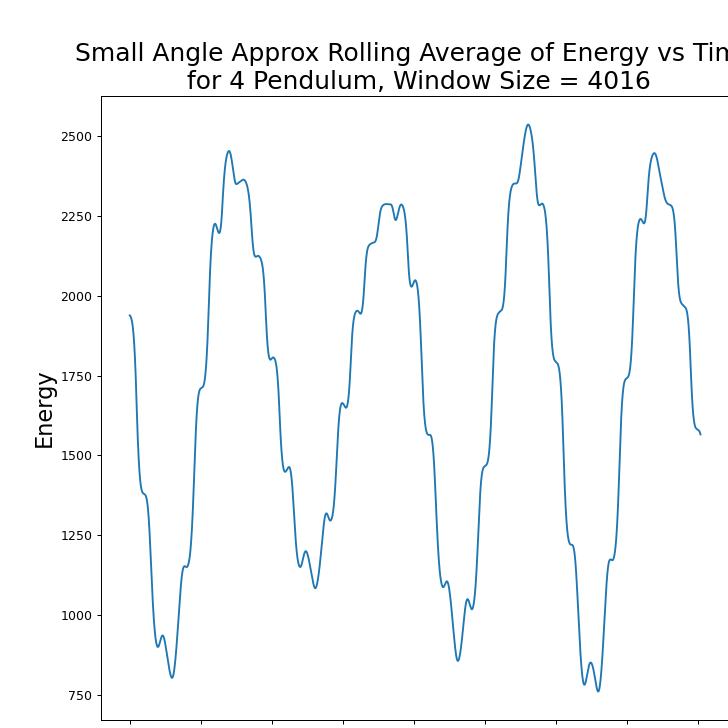

In [15]:
# Determining energy plots
dtname = "_identical_mass_identical_length_init_angle_3pi_over_4"
get_energy(x_t, y_t, xdot_t, ydot_t, r_t, v_t, h_t, n, l, m, mode = "acc", winsize = 11046, filename1 = dtname, filename2 = dtname, save_cond = True)
get_energy(x_t, y_t, xdot_t, ydot_t, r_t, v_t, h_t, n, l, m, mode = "approx", winsize = 4016, filename1 = dtname, filename2 = dtname, save_cond = True)